# TP02 Regularization

In this TP, we aim to proove the way the Elastic Net method selects the variable is better than the Lasso's when we have in the dataset highly correlated features on the same scale. To do this, our startegy is :
- Define desired dataset described above.
- Define risk computing function.
- Find the hyperparameters of 2 regressions by the Cross-Validation method in order to calculate the comparable risks.
- Plot the stability of 2 methods by repeating the variable-selection process and conclude the stability of selecting variables from 2 regression methods.

In [1]:
from scipy import linalg
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV
import numpy as np
import matplotlib.pyplot as plt


"""
Define the function generating the highly correlated features on the same scale. The idea is first to create the 2 different
features Z1 and Z2 by genereating the uniform distribution function ; then to create the 3 first columns of X based on Z1 and
the last 3 based on Z2. At the end, we calculated the model's output y.
"""
class Event_personalise:
    def __init__(self):
        self.n_features = 6

    def sample(self, n_samples=1000):
        self.Z1 = np.random.uniform(0, 30, n_samples)
        self.Z2 = np.random.uniform(0, 30, n_samples)
        X = np.zeros((n_samples, 6))
        y = np.zeros((n_samples, 1))
        
        X[:, 0] = self.Z1 + np.random.normal(0, 0.5, n_samples)
        X[:, 1] = -self.Z1 + np.random.normal(0, 0.5, n_samples)
        X[:, 2] = self.Z1 + np.random.normal(0, 0.5, n_samples)
        
        X[:, 3] = self.Z2 + np.random.normal(0, 0.5, n_samples)
        X[:, 4] = -self.Z2 + np.random.normal(0, 0.5, n_samples)
        X[:, 5] = self.Z2 + np.random.normal(0, 0.5, n_samples)
        
        y = self.Z1 + 0.1*self.Z2 + np.random.normal(0, 1, n_samples)

        return X, y

In [2]:
"""
The risk computing function calculates the risk value corresponding to the specific model.
"""

def compute_risk(model, evt, ntimes, n_samples, Z10, Z20):
    pred_model = []
    y0 = Z10 + 0.1*Z20                                 # "true" ouput
    X0 = np.zeros((1, 6))                              # input
    X0[0, 0] = Z10 + np.random.normal(0, 0.5, 1)
    X0[0, 1] = -Z10 + np.random.normal(0, 0.5, 1)
    X0[0, 2] = Z10 + np.random.normal(0, 0.5, 1)

    X0[0, 3] = Z20 + np.random.normal(0, 0.5, 1)
    X0[0, 4] = -Z20 + np.random.normal(0, 0.5, 1)
    X0[0, 5] = Z20 + np.random.normal(0, 0.5, 1)
    for i in range(ntimes):                            # run n-times to predict n-times ouput values
        X, y = evt.sample(n_samples=n_samples)
        model.fit(X, y)
        pred = model.predict(X0)
        pred_model.append(pred)
        
    risk = np.mean((pred_model - y0)**2)               # calculate the risk value
    return risk

In [3]:
"""
Find the hyperparameters of 2 regression methods by using the cross-validation technique.
"""

evt = Event_personalise()
X, y = evt.sample(n_samples=1000)
lasso_alpha = LassoCV(cv=5, random_state=0).fit(X, y).alpha_
print('Best alpha for lasso is %f' % lasso_alpha)
elas_alpha = ElasticNetCV(cv=20, random_state=0).fit(X, y).alpha_
elas_l1ratio = ElasticNetCV(cv=20, random_state=0).fit(X, y).l1_ratio_
print('Best alpha, l1 for elas is {}, {}'.format(elas_alpha, elas_l1ratio))

Best alpha for lasso is 0.071942
Best alpha, l1 for elas is 0.17738650054369254, 0.5


In [4]:
"""
Comapre the 2 risk values from the found hyperparameters and the risk computing function.
"""

ntimes = 100
Z10 = np.random.uniform(0, 30, 1)
Z20 = np.random.uniform(0, 30, 1)
n_samples = 1000
risk_lasso = compute_risk(Lasso(alpha=lasso_alpha), evt, ntimes, n_samples, Z10, Z20)
risk_elas = compute_risk(ElasticNet(alpha=elas_alpha, l1_ratio=elas_l1ratio), evt, ntimes, n_samples, Z10, Z20)
output = "Risk: %f"
print("Lasso regression: ", output % risk_lasso)
print("Elastic net regression: ", output % risk_elas)

Lasso regression:  Risk: 0.046911
Elastic net regression:  Risk: 0.096942


In [5]:
"""
Display the freauency of features selected and evaluate the stability of 2 methods.
"""

N = 100
lassoRes = []
ElasticRes = []
for i in range (0,N):
    evt = Event_personalise()
    X, y = evt.sample(n_samples=1000)

    columns = np.arange(X.shape[1])
    sel_1 = SelectFromModel(Lasso(alpha=lasso_alpha))
    sel_1.fit(X, y)
    lassoVar = list(columns[(sel_1.get_support())])
    lassoRes.append(lassoVar)

    sel_2 = SelectFromModel(ElasticNet(alpha=elas_alpha, l1_ratio=elas_l1ratio))
    sel_2.fit(X, y)
    ElasticVar = list(columns[(sel_2.get_support())])
    ElasticRes.append(ElasticVar)
    
feature = range(6)
freq_Elas = np.zeros(6)
freq_Lass = np.zeros(6)
for i in feature:
    for j in range(len(ElasticRes)):
        if i in ElasticRes[j]:
            freq_Elas[i] += 1
    for j in range(len(lassoRes)):
        if i in lassoRes[j]:
            freq_Lass[i] += 1

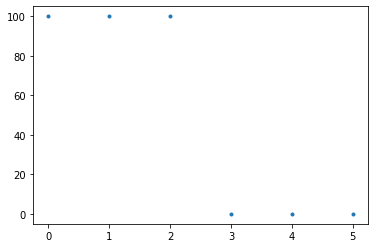

In [6]:
plt.plot(feature, freq_Elas, '.')

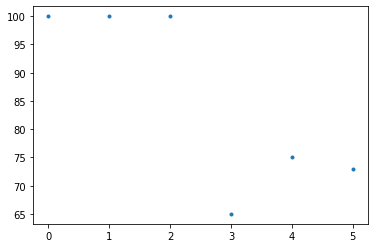

In [7]:
plt.plot(feature, freq_Lass, '.')

From the 2 above figures, we find that the selected features of Elastic Net method are always X0, X1 and X2 while the variable selection of Lasso method is not always the same in every case (X3, X4 and X5 are not clearly selected, meaning their frequencies between 65 and 70).